<a href="https://colab.research.google.com/github/Hessah778/ProjectML/blob/main/MLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

description of the issue: Email Spam Classification 
ML technique: NLP

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
data = pd.read_csv('/content/Spam Email raw text for NLP.csv')

In [ ]:
data

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6
...,...,...,...
5791,0,"I'm one of the 30,000 but it's not working ver...",00609.dd49926ce94a1ea328cce9b62825bc97
5792,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",01127.841233b48eceb74a825417d8d918abf8
5794,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",01178.5c977dff972cd6eef64d4173b90307f0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CATEGORY   5796 non-null   int64 
 1   MESSAGE    5796 non-null   object
 2   FILE_NAME  5796 non-null   object
dtypes: int64(1), object(2)
memory usage: 136.0+ KB


In [ ]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=None):
    sequences = tokenizer.texts_to_sequences(texts)
     #converts the text into sequences
    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
    #the max sequences length
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences

In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop FILE_NAME column
    df = df.drop('FILE_NAME', axis=1)
    
    # Split df into X and y
    y = df['CATEGORY']
    X = df['MESSAGE']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Create tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=30000)
    
    # Fit the tokenizer
    tokenizer.fit_on_texts(X_train)
    
    # Convert texts to sequences
    X_train = get_sequences(X_train, tokenizer, train=True)
    X_test = get_sequences(X_test, tokenizer, train=False, max_seq_length=X_train.shape[1])
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [ ]:
X_train

array([[   14,   135,   188, ...,     0,     0,     0],
       [  183,  1452,  2119, ...,     0,     0,     0],
       [   56,   129,    20, ...,     0,     0,     0],
       ...,
       [  309,    12,    32, ...,     0,     0,     0],
       [   56,   179,   298, ...,     0,     0,     0],
       [   94,  4671, 11648, ...,     0,     0,     0]], dtype=int32)

In [ ]:
y_train.value_counts()

0    2738
1    1319
Name: CATEGORY, dtype: int64

In [ ]:
X_train.shape

(4057, 14804)

In [ ]:
inputs = tf.keras.Input(shape=(14804,))
#input->word  output->dense space we choose 64
embedding = tf.keras.layers.Embedding(
    input_dim=30000,
    output_dim=64
)(inputs)
#take embeddings and flatting into singel vector
flatten = tf.keras.layers.Flatten()(embedding)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)


model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14804)]           0         
                                                                 
 embedding (Embedding)       (None, 14804, 64)         1920000   
                                                                 
 flatten (Flatten)           (None, 947456)            0         
                                                                 
 dense (Dense)               (None, 1)                 947457    
                                                                 
Total params: 2,867,457
Trainable params: 2,867,457
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
102/102 [==============================] - 19s 175ms/step - loss: 0.6840 - accuracy: 0.8139 - auc: 0.8132 - val_loss: 0.1151 - val_accuracy: 0.9643 - val_auc: 0.9959
Epoch 2/100
102/102 [==============================] - 17s 170ms/step - loss: 0.0533 - accuracy: 0.9864 - auc: 0.9995 - val_loss: 0.0418 - val_accuracy: 0.9901 - val_auc: 0.9988
Epoch 3/100
102/102 [==============================] - 18s 173ms/step - loss: 0.0160 - accuracy: 0.9972 - auc: 1.0000 - val_loss: 0.0332 - val_accuracy: 0.9877 - val_auc: 0.9992
Epoch 4/100
102/102 [==============================] - 17s 171ms/step - loss: 0.0074 - accuracy: 0.9994 - auc: 1.0000 - val_loss: 0.0313 - val_accuracy: 0.9901 - val_auc: 0.9991
Epoch 5/100
102/102 [==============================] - 17s 168ms/step - loss: 0.0047 - accuracy: 0.9994 - auc: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9889 - val_auc: 0.9993
Epoch 6/100
102/102 [==============================] - 17s 168ms/step - loss: 0.0033 - accuracy: 0.9994 - auc:

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb= MultinomialNB()
nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)

the confusion matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


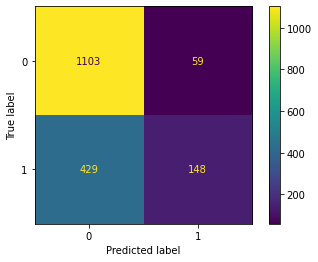

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(nb,X_test,y_test)

analysis the results

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)

print("    Test Loss: {:.4f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("     Test AUC: {:.4f}".format(results[2]))

    Test Loss: 0.0226
Test Accuracy: 99.31%
     Test AUC: 0.9989
